# **Naive Bayes**

## **Introduction to Naive Bayes**

Naive Bayes classification is a method used to sort data into categories based on probability. It's built on Bayes' Theorem and assumes that the features, or attributes of the data, are independent when you know the category. In simple terms, it uses the formula $ (P(\text{Class}|\text{Features}) = \frac{P(\text{Features}|\text{Class}) \times P(\text{Class})}{P(\text{Features})}) $ to find out which category is most likely given a set of features.

There are different types of Naive Bayes classifiers based on the kind of data you have. Gaussian Naive Bayes is used when the features are continuous and assumes a normal distribution. Multinomial Naive Bayes is best for count data, like the number of times a word appears in a text. Bernoulli Naive Bayes is used for binary data and assumes a Bernoulli distribution.By picking the right type of Naive Bayes for a model, you can create a simple and effective model to classify data. Even though it makes a basic assumption about feature independence, Naive Bayes can be a strong classifcation tool for sorting data into categories.

In my analysis, I will be training a Gaussian Naive Bayes model on my record data with the goal using my financial data to predict what Clearance Type will be assigned to a medical device of applying for 510(K) clearance. I suspect that companies with stronger financial metrics will be more likely to receive a 510(K) special clearance due to the resources they have avaliable.

I will also be training a Multinomial Gaussian Naive Bayes model on my text data, the Company description section of from a Company's annual SEC 10-K finanical filing, which I pulled from the SEC database using R in my data cleaning section. I will be using this model to predict what Advisory Committee will be assigned to a medical device applying for 510(K) clearance as a proxy for what industries a company is involved in.

## **Naive Bayes for Record Data**

### **Extracting Data**

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading in record data

filtered_df = pd.read_csv('../data-exploration/outputs/filtered.csv')

# Extracting relevant variables

x = filtered_df[['GrossProfit', 'CostsAndExpenses', 'SG&A', 'ProfitLoss']].values # Features
y = filtered_df['clearance_type'].values # Target variable

Let's build a function for training the model

In [3]:
# Importing necessary libraries
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import random

# Define a function to train a Gaussian Naive Bayes model
def train_GNB_model(x_train, y_train, x_test, y_test, i_print=False):
        
    # Initialize the Gaussian Naive Bayes classifier
    gnb = GaussianNB()

    # Train the classifier using the training data
    gnb.fit(x_train, y_train)

    # Predict the class labels for both training and test sets
    y_train_pred = gnb.predict(x_train)
    y_test_pred = gnb.predict(x_test)

    # Calculate the accuracy of the model on the training and test sets
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # If i_print is True, print the training accuracy, test accuracy, and classification report
    if i_print:
            # Print the accuracies
            print("Training Accuracy:", str(train_accuracy*100) +"%")
            print("Test Accuracy:", str(test_accuracy*100) +"%")
            # Print the classification report which includes precision, recall, and F1-score
            print("Classification Report:\n", classification_report(y_test, y_test_pred))
            
    # Return the training and test accuracies
    return train_accuracy, test_accuracy

### **Feature Selection Hyperparameter Optimization**

In [4]:
# SET INDICES FOR TRAIN/TEST SET
N=x.shape[0]
l = [*range(N)]       # indices
cut = int(0.7 * N)    # 80% of the list
random.shuffle(l)     # randomize
train_index = l[:cut] # first 80% of shuffled list
test_index = l[cut:]  # last 20% of shuffled list

In [5]:
# COMPUTE UPPER AND LOWER LIMIT FOR VARIANCE ACCROSS SAMPLES
x_var=np.var(x,axis=0)
print(np.min(x_var))
print(np.max(x_var))

2.1845247900753636e+16
1.1636247134149425e+18


In [6]:
# VARIANCE THRESHOLD SEARCH

from sklearn.feature_selection import VarianceThreshold

# DEFINE GRID OF THRESHOLDS 
num_thresholds=30
thresholds=np.linspace(np.min(x_var),np.max(x_var),num_thresholds)

# DOESN"T WORK WELL WITH EDGE VALUES (ZERO VAR)
thresholds=thresholds[1:-2]; #print(thresholds)

# INITIALIZE ARRAYS
num_features=[]
train_accuracies=[]
test_accuracies=[]

# INITIALIZE BEST VALUES
best_acc_test = 0  
best_threshold = 0
best_feature_indices = []


#FULL TRAINING SET
x_train=x[train_index]; y_train=y[train_index]
x_test=x[test_index]; y_test=y[test_index]
(acc_train,acc_test)=train_GNB_model(x_train,y_train,x_test,y_test,i_print=False)
num_features.append(x_train.shape[1])
train_accuracies.append(acc_train)
test_accuracies.append(acc_test)

# SEARCH FOR OPTIMAL THRESHOLD
for THRESHOLD in thresholds:
    feature_selector = VarianceThreshold(threshold=THRESHOLD)
    xtmp=feature_selector.fit_transform(x)

    x_train=xtmp[train_index]; y_train=y[train_index]
    x_test=xtmp[test_index]; y_test=y[test_index]

    (acc_train,acc_test)=train_GNB_model(x_train,y_train,x_test,y_test,i_print= False)
             
    #RECORD 
    num_features.append(xtmp.shape[1])
    train_accuracies.append(acc_train)
    test_accuracies.append(acc_test)

    if acc_test > best_acc_test:
        best_acc_test = acc_test
        best_threshold = THRESHOLD
        best_feature_indices = feature_selector.get_support(indices=True)

print("Best Threshold:", best_threshold)
print("Best Test Accuracy:", round(float(best_acc_test),2) * 100,'%')
print("Best Feature Indices:", best_feature_indices)

Best Threshold: 5.730491278041552e+17
Best Test Accuracy: 60.0 %
Best Feature Indices: [1]


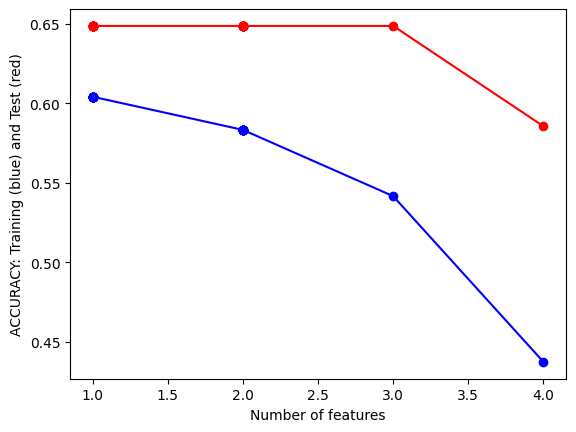

In [7]:
plt.plot(num_features,train_accuracies,'-or')
plt.plot(num_features,test_accuracies,'-ob')
plt.xlabel('Number of features')
plt.ylabel('ACCURACY: Training (blue) and Test (red)')
plt.show()

### **Running the Model**

In [8]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x[:,best_feature_indices], y, test_size=0.2, random_state=1)

train_GNB_model(x_train,y_train,x_test,y_test,i_print=True)

Training Accuracy: 62.99212598425197%
Test Accuracy: 68.75%
Classification Report:
               precision    recall  f1-score   support

      Direct       0.00      0.00      0.00         2
  Dual Track       0.00      0.00      0.00         0
     Special       0.00      0.00      0.00         7
 Traditional       0.71      0.96      0.81        23

    accuracy                           0.69        32
   macro avg       0.18      0.24      0.20        32
weighted avg       0.51      0.69      0.59        32



/Users/dsan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dsan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dsan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dsan/anaconda3/lib/python3.10/si

(0.6299212598425197, 0.6875)

### **Interepreting Results**

Analyzing the results of my model, I observe a training accuracy of approximately 62.99% and a test accuracy of 68.75%. The higher test accuracy compared to the training accuracy suggests that my model is generalizing well to unseen data and is not overfitting to the training set.

However, examining the classification report, I notice significant disparities in the model's performance across the four classes: "Direct", "Dual Track", "Special", and "Traditional". The model performs well in predicting the "Traditional" class, with a precision of 0.71 and a recall of 0.96, leading to an F1-score of 0.81. This suggests that the model is effectively identifying and correctly classifying the majority of instances in this category.

Contrastingly, the model struggles with the "Direct" and "Special" classes, failing to correctly identify any instances, as indicated by the precision and recall values of 0.00. The "Dual Track" class shows a precision of 0.00 but does not have any instances in the test set, indicated by a support of 0. This indicates potential issues with class imbalance and a need for stratified sampling.

The overall accuracy of the model is 68.75%, which is skewed by the strong performance in the "Traditional" category. However, the macro average precision, recall, and F1-score, which are around 0.18, 0.24, and 0.20 respectively, reveal that the model's performance is not uniform across classes.

While the model demonstrates good generalization with a test accuracy higher than the training accuracy, the disparities in class-wise performance indicate areas for improvement. To enhance the model, I might consider addressing the class imbalance, experimenting with different feature engineering techniques, or exploring alternative models and resampling methods to boost the model's ability to identify the underrepresented classes. Overall, I think that there's a lack of quality data for this model to train on, which is why it is struggling to predict the "Direct" and "Special" classes. In the future, I'll look to bolster my analysis with higher quality and more robust data.


### **Naive Bayes with Text Data**

### **Extracting Data**

In [12]:
# Import necessary libraries
from sklearn.feature_extraction.text import CountVectorizer
import glob

# Initialize an empty list to store business descriptions along with SEC_cik and financial_year
descriptions_list = []

# Loop through every row in the filtered_df DataFrame
for index, row in filtered_df.iterrows():

    # Access the value for the SEC_cik column and financial_year column for the current row
    cik = row['SEC_cik']
    year = row['financial_year']

    try:
        # Construct the file name pattern and search for the matching file
        # The glob pattern assumes the file is in a specific folder and follows a specific naming convention
        file_name = glob.glob('../data-cleaning/outputs/SEC-Edgar/Business descriptions text/' + str(cik) + '_10-K_' + str(year) + '-*.txt')[0]

        # Open and read the content of the file
        with open(file_name, 'r') as f:
            text = f.read()

            # Append a dictionary containing SEC_cik, financial_year, and the read business description to the list
            descriptions_list.append({"SEC_cik": cik, "financial_year": year, "business_description": text})
    except:
        # If an error occurs (e.g., file not found), skip to the next iteration
        continue

# Convert the list of dictionaries to a DataFrame
descriptions_df = pd.DataFrame(descriptions_list)
descriptions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   SEC_cik               112 non-null    int64 
 1   financial_year        112 non-null    int64 
 2   business_description  112 non-null    object
dtypes: int64(2), object(1)
memory usage: 2.8+ KB


In [13]:
# Merge filtered_df and descriptions_df DataFrames on 'SEC_cik' and 'financial_year' columns using an inner join
# This ensures that only rows with matching 'SEC_cik' and 'financial_year' in both DataFrames are included in the merged_df
merged_df = pd.merge(filtered_df, descriptions_df, on=['SEC_cik', 'financial_year'], how='inner')

# Drop duplicate rows based on the 'device_name' column, keeping only the first occurrence
merged_df = merged_df.drop_duplicates(subset='device_name')

# Extract features and target variable
corpus = merged_df["business_description"].to_list() #features
advisory_committee = merged_df["advisory_committee"].to_list() #target variable

### **Feature Selection Hyperparameter Optimization**

#### **Building Functions for feature selection and model training**

In [14]:
def vectorize(corpus, MAX_FEATURES):
    # Initialize CountVectorizer with a maximum number of features to consider and English stop words to be removed
    vectorizer = CountVectorizer(max_features=MAX_FEATURES, stop_words="english")

    # Fit the vectorizer on the given corpus and transform the corpus into a sparse matrix of word counts
    Xs = vectorizer.fit_transform(corpus)

    # Convert the sparse matrix to a dense matrix
    X = np.array(Xs.todense())

    # Convert word counts to one-hot vectors by normalizing with the maximum count for each word across the corpus
    # The use of np.ceil ensures that any non-zero count is treated as 1
    maxs = np.max(X, axis=0)
    one_hot_vectors = np.ceil(X / maxs)

    # Return the one-hot vectors and the vocabulary learned by the vectorizer
    return (one_hot_vectors, vectorizer.vocabulary_)


In [15]:
(x,vocab0)=vectorize(corpus,MAX_FEATURES=10000)
print(x.shape,y.shape)

df2=pd.DataFrame(x)
s = df2.sum(axis=0)
df2=df2[s.sort_values(ascending=False).index[:]]
print(df2.head())

print()

vocab1 = dict([(value, key) for key, value in vocab0.items()])

i1=0
vocab2={}
for i2 in list(df2.columns):
    # print(i2)
    vocab2[i1]=vocab1[int(i2)]
    i1+=1


# RENAME COLUMNS 0,1,2,3 .. 
df2.columns = range(df2.columns.size)
print(df2.head())
print(df2.sum(axis=0))
x=df2.to_numpy()

(106, 10000) (159,)
   7693  1731  6440  1363  4363  7916  2447  1300  6437  1652  ...  9633  \
0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   0.0   
1   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   0.0   
2   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   0.0   
3   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   0.0   
4   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   0.0   

   9632  8972  705   3270  4529  4527  4526  3276  8620  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 10000 columns]

   0     1     2     3     4     5     6     7     8     9     ...  9990  \
0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   0.0

In [16]:
import random
N=x.shape[0]
l = [*range(N)]     # indices
cut = int(0.8 * N) #80% of the list
random.shuffle(l)   # randomize
train_index = l[:cut] # first 80% of shuffled list
test_index = l[cut:] # last 20% of shuffled list

print(train_index[0:10])
print(test_index[0:10])

[10, 74, 34, 96, 89, 55, 12, 24, 59, 98]
[101, 75, 58, 80, 84, 76, 23, 38, 53, 7]


In [17]:
from sklearn.naive_bayes import MultinomialNB
import time

def train_MNB_model(X,Y,i_print=False):

    if(i_print):
        print(X.shape,Y.shape)

    #SPLIT
    x_train=X[train_index]
    y_train=Y[train_index].flatten()

    x_test=X[test_index]
    y_test=Y[test_index].flatten()

    # INITIALIZE MODEL 
    model = MultinomialNB()

    # TRAIN MODEL 
    start = time.process_time()
    model.fit(x_train,y_train)
    time_train=time.process_time() - start

    # LABEL PREDICTIONS FOR TRAINING AND TEST SET 
    start = time.process_time()
    yp_train = model.predict(x_train)
    yp_test = model.predict(x_test)
    time_eval=time.process_time() - start

    acc_train= accuracy_score(y_train, yp_train)*100
    acc_test= accuracy_score(y_test, yp_test)*100

    if(i_print):
        print(acc_train,acc_test,time_train,time_eval)

    return (acc_train,acc_test,time_train,time_eval)


#TEST
print(type(x),type(y))
print(x.shape,y.shape)
(acc_train,acc_test,time_train,time_eval)=train_MNB_model(x,y,i_print=True)


<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(106, 10000) (159,)
(106, 10000) (159,)
77.38095238095238 68.18181818181817 0.025561999999999863 0.051115000000000244


In [18]:
##UTILITY FUNCTION TO INITIALIZE RELEVANT ARRAYS
def initialize_arrays():
    global num_features,train_accuracies
    global test_accuracies,train_time,eval_time
    num_features=[]
    train_accuracies=[]
    test_accuracies=[]
    train_time=[]
    eval_time=[]


In [19]:
#UTILITY FUNCTION TO SAVE RESULTS
def save_results(path_root):
    out=np.transpose(np.array([num_features,train_accuracies,test_accuracies,train_time,eval_time])) 
    out=pd.DataFrame(out)
    out.to_csv(path_root+".csv")


In [20]:
#UTILITY FUNCTION TO PLOT RESULTS
def plot_results(path_root):

    #PLOT-1
    plt.plot(num_features,train_accuracies,'-or')
    plt.plot(num_features,test_accuracies,'-ob')
    plt.xlabel('Number of features')
    plt.ylabel('ACCURACY: Training (blue) and Test (red)')
    plt.savefig(path_root+'-1.png')
    plt.show()

    # #PLOT-2
    plt.plot(num_features,train_time,'-or')
    plt.plot(num_features,eval_time,'-ob')
    plt.xlabel('Number of features')
    plt.ylabel('Runtime: training time (red) and evaluation time(blue)')
    plt.savefig(path_root+'-2.png')
    plt.show()

    # #PLOT-3
    plt.plot(np.array(test_accuracies),train_time,'-or')
    plt.plot(np.array(test_accuracies),eval_time,'-ob')
    plt.xlabel('test_accuracies')
    plt.ylabel('Runtime: training time (red) and evaluation time (blue)')
    plt.savefig(path_root+'-3.png')
    plt.show()

    # #PLOT-3
    plt.plot(num_features,np.array(train_accuracies)-np.array(test_accuracies),'-or')
    plt.xlabel('Number of features')
    plt.ylabel('train_accuracies-test_accuracies')
    plt.savefig(path_root+'-4.png')
    plt.show()


#### **Running Feature Selection Optimization**

In [21]:
# INITIALIZE ARRAYS
initialize_arrays()

# DEFINE SEARCH FUNCTION
def partial_grid_search(num_runs, min_index, max_index):
    for i in range(1, num_runs+1):
        # SUBSET FEATURES 
        upper_index=min_index+i*int((max_index-min_index)/num_runs)
        xtmp=x[:,0:upper_index]

        #TRAIN 
        (acc_train,acc_test,time_train,time_eval)=train_MNB_model(xtmp,y,i_print=False)

        if(i%5==0):
            print(i,upper_index,xtmp.shape[1],acc_train,acc_test)
            
        #RECORD 
        num_features.append(xtmp.shape[1])
        train_accuracies.append(acc_train)
        test_accuracies.append(acc_test)
        train_time.append(time_train)
        eval_time.append(time_eval)

# DENSE SEARCH (SMALL NUMBER OF FEATURES (FAST))
partial_grid_search(num_runs=100, min_index=0, max_index=1000)

# SPARSE SEARCH (LARGE NUMBER OF FEATURES (SLOWER))
partial_grid_search(num_runs=20, min_index=1000, max_index=10000)


5 50 50 76.19047619047619 68.18181818181817
10 100 100 76.19047619047619 68.18181818181817
15 150 150 76.19047619047619 68.18181818181817
20 200 200 76.19047619047619 68.18181818181817
25 250 250 76.19047619047619 68.18181818181817
30 300 300 77.38095238095238 68.18181818181817
35 350 350 79.76190476190477 68.18181818181817
40 400 400 79.76190476190477 68.18181818181817
45 450 450 79.76190476190477 68.18181818181817
50 500 500 80.95238095238095 68.18181818181817
55 550 550 78.57142857142857 63.63636363636363
60 600 600 78.57142857142857 63.63636363636363
65 650 650 78.57142857142857 68.18181818181817
70 700 700 78.57142857142857 68.18181818181817
75 750 750 60.71428571428571 77.27272727272727
80 800 800 60.71428571428571 77.27272727272727
85 850 850 60.71428571428571 77.27272727272727
90 900 900 60.71428571428571 77.27272727272727
95 950 950 61.904761904761905 72.72727272727273
100 1000 1000 63.095238095238095 81.81818181818183
5 3250 3250 55.952380952380956 40.909090909090914
10 5500 

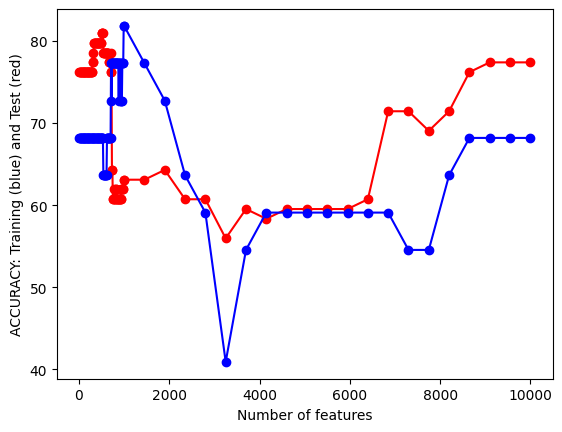

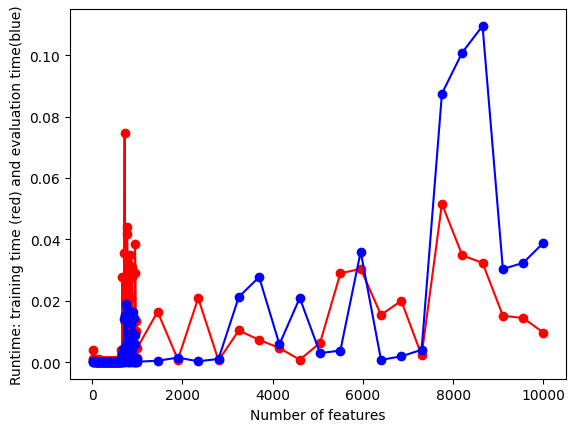

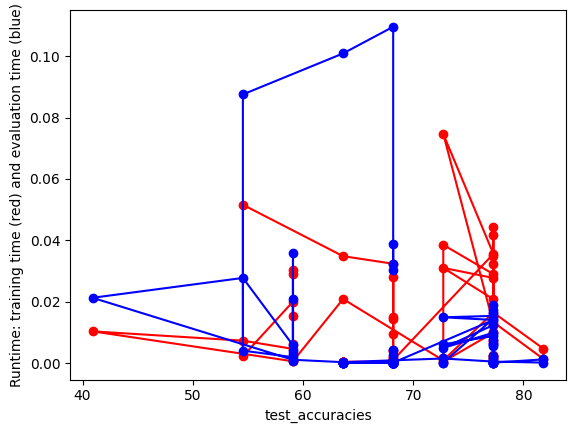

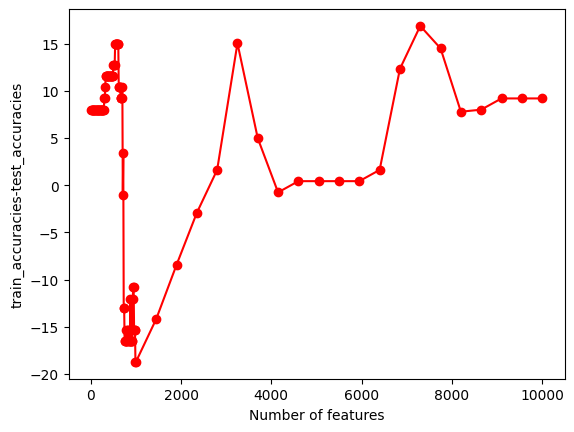

In [22]:
output_dir = "./outputs/"

save_results(output_dir+"partial_grid_search")
plot_results(output_dir+"partial_grid_search")

In [23]:
x_var=np.var(x,axis=0)
print(np.min(x_var))
print(np.max(x_var))

0.0
0.25


In [24]:

# DEFINE GRID OF THRESHOLDS 
num_thresholds=30
thresholds=np.linspace(np.min(x_var),np.max(x_var),num_thresholds)

#DOESN"T WORK WELL WITH EDGE VALUES 
thresholds=thresholds[1:-2]; #print(thresholds)

# INITIALIZE ARRAYS
initialize_arrays()

# SEARCH FOR OPTIMAL THRESHOLD
for THRESHOLD in thresholds:
    feature_selector = VarianceThreshold(threshold=THRESHOLD)
    xtmp=feature_selector.fit_transform(x)
    print("THRESHOLD =",THRESHOLD, xtmp.shape[1])

    (acc_train,acc_test,time_train,time_eval)=train_MNB_model(xtmp,y,i_print=False)
             
    #RECORD 
    num_features.append(xtmp.shape[1])
    train_accuracies.append(acc_train)
    test_accuracies.append(acc_test)
    train_time.append(time_train)
    eval_time.append(time_eval)


THRESHOLD = 0.008620689655172414 9928
THRESHOLD = 0.017241379310344827 9326
THRESHOLD = 0.02586206896551724 8718
THRESHOLD = 0.034482758620689655 7944
THRESHOLD = 0.04310344827586207 7355
THRESHOLD = 0.05172413793103448 6724
THRESHOLD = 0.06034482758620689 6395
THRESHOLD = 0.06896551724137931 6022
THRESHOLD = 0.07758620689655173 5793
THRESHOLD = 0.08620689655172414 4899
THRESHOLD = 0.09482758620689655 4663
THRESHOLD = 0.10344827586206896 4464
THRESHOLD = 0.11206896551724138 4277
THRESHOLD = 0.12068965517241378 3936
THRESHOLD = 0.12931034482758622 3523
THRESHOLD = 0.13793103448275862 3363
THRESHOLD = 0.14655172413793102 3232
THRESHOLD = 0.15517241379310345 2858
THRESHOLD = 0.16379310344827586 2723
THRESHOLD = 0.1724137931034483 2483
THRESHOLD = 0.1810344827586207 2250
THRESHOLD = 0.1896551724137931 2146
THRESHOLD = 0.19827586206896552 1948
THRESHOLD = 0.20689655172413793 1733
THRESHOLD = 0.21551724137931033 1438
THRESHOLD = 0.22413793103448276 1266
THRESHOLD = 0.23275862068965517 983


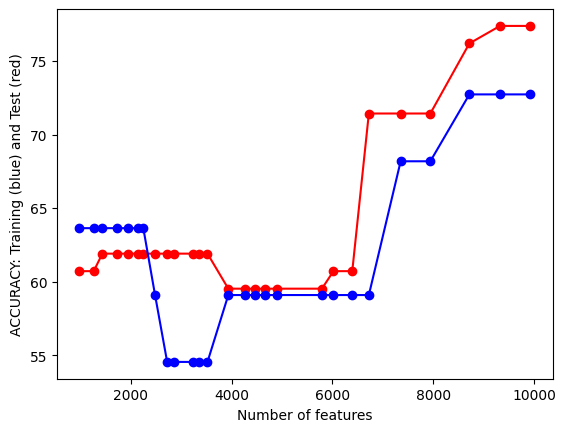

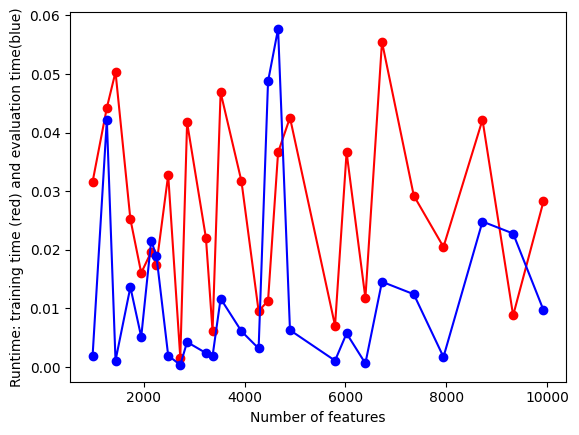

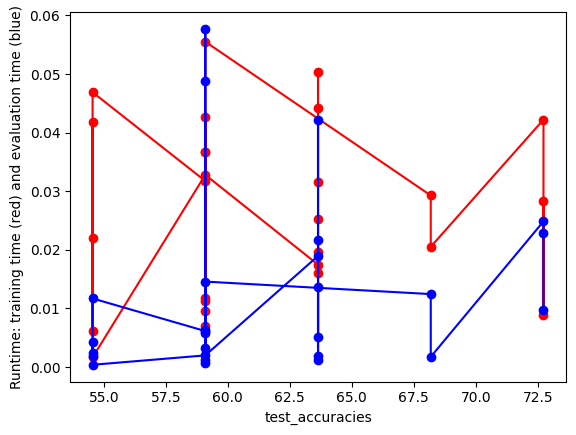

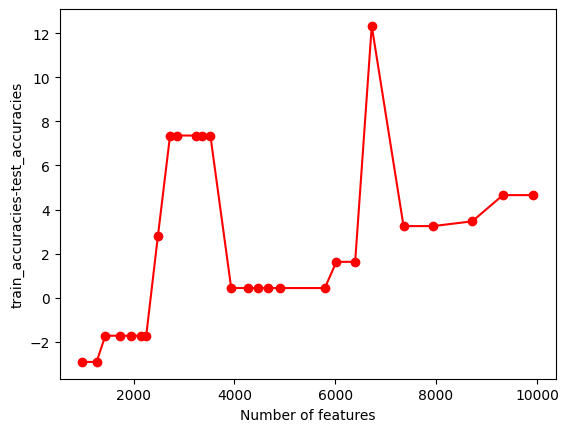

In [25]:
# CHECK RESULTS 
save_results(output_dir+"/variance_threshold")
plot_results(output_dir+"/variance_threshold")


### **Running the Optimized Model**

In [30]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, advisory_committee, test_size=0.2, random_state=1)

# Initialize a Multinomial Naive Bayes classifier
clf = MultinomialNB()

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6363636363636364
Classification Report:
                            precision    recall  f1-score   support

           Cardiovascular       0.50      1.00      0.67         1
       Clinical Chemistry       1.00      0.67      0.80         3
Gastroenterology, Urology       0.75      1.00      0.86         3
         General Hospital       1.00      0.25      0.40         4
 General, Plastic Surgery       0.25      0.50      0.33         2
               Immunology       0.00      0.00      0.00         1
             Microbiology       0.67      1.00      0.80         4
                Neurology       0.00      0.00      0.00         1
    Obstetrics/Gynecology       1.00      1.00      1.00         2
               Orthopedic       0.00      0.00      0.00         1

                 accuracy                           0.64        22
                macro avg       0.52      0.54      0.49        22
             weighted avg       0.68      0.64      0.60        22



/Users/dsan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dsan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dsan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **Interpreting Results**

Analyzing the classification report from my Multinomial Naive Bayes model, I observe a range of performances across different classes. For instance, the "Clinical Chemistry" and "Obstetrics/Gynecology" classes are high performers with high precision and recall, indicating that the model is accurately identifying and classifying these samples correctly.

On the other hand, I notice that the model struggles with the "Immunology", "Neurology", and "Orthopedic" classes, where both precision and recall are at 0. This suggests that the model is unable to correctly identify any samples from these categories, highlighting an area that requires improvement.

For the "Cardiovascular" and "Gastroenterology, Urology" classes, the recall is 1.00, which is promising. However, the precision is less than perfect, indicating that the model is misclassifying some samples from other classes into these categories.

In the case of "General Hospital", the precision is high at 1.00, but the recall is low at 0.25. This indicates that while the model is confident in its predictions for this class, it is missing several samples that should have been classified into this category.

I also notice that the "Support" values vary across classes, pointing to an imbalance in the dataset. The classes with lower support tend to have lower precision and recall scores, which suggests that the model may benefit from techniques to address this class imbalance, such as resampling or adjusting class weights.

The accuracy of the model stands at 0.64, indicating that 64% of all instances were correctly predicted. While this is a decent starting point, the variability in precision, recall, and F1-scores across classes suggests that there are opportunities for fine-tuning and improvement. I might explore feature engineering, parameter tuning, and addressing the class imbalance to enhance the model's performance further. Overall, the model performed poorly due to the class imbalance in the dataset, which is a result of low quality data. In the future, I will look to bolster my dataset with more robust and higher quality data to improve the model's performance.